In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('log2.csv')

In [3]:
df.duplicated().sum()

8362

In [4]:
df.shape

(65532, 12)

In [5]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [6]:
df.isna().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

# Change to categorical type features

Source Port: bin into 3 categories well known, registerd, dynamic/private

Destination Port

NAT Source
NAT Destination 

# Bin the columns into groups

In [7]:
src_bins = [0,1023,49151,65535]
labels = ['well-known','registered','dynamic/private']

df['src_port_category'] = pd.cut(df['Source Port'], bins = src_bins,
                                labels=labels, right = True, include_lowest=True)

In [8]:
des_bins = [0,1023,49151,65535]
labels = ['well-known','registered','dynamic/private']

df['des_port_category'] = pd.cut(df['Destination Port'], bins = des_bins,
                                 labels=labels, right = True, include_lowest=True)



In [9]:
nat_src_bins = [0,1023,49151,65535]
labels = ['well-known','registered','dynamic/private']

df['nat_src_category'] = pd.cut(df['NAT Source Port'], bins = nat_src_bins,
                                labels=labels,include_lowest=True,right=True)

In [10]:
nat_des_bins = [0,1023,49151,65535]
labels = ['well-known','registered','dynamic/private']

df['nat_des_category'] = pd.cut(df['NAT Destination Port'], bins=nat_des_bins,
                                labels= labels, include_lowest=True,right = True)

# Drop the original columns

In [11]:
df.drop(['Source Port','Destination Port',
        'NAT Source Port','NAT Destination Port'], axis=1, inplace = True)

# Look as target distribution

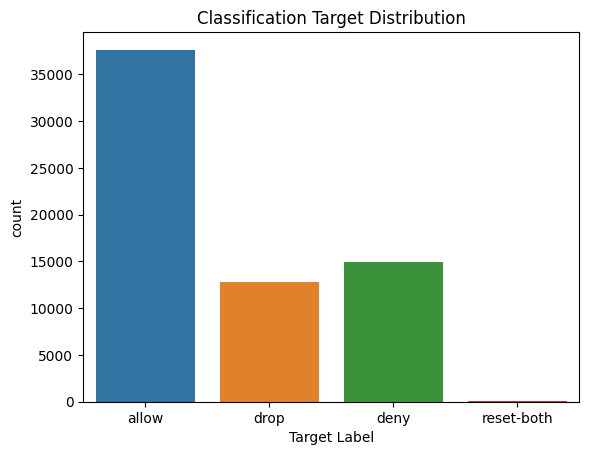

In [12]:
sns.countplot(data = df, x ='Action')
plt.title('Classification Target Distribution')
plt.xlabel('Target Label')
plt.show()

In [13]:
df['Action'].value_counts()

Action
allow         37640
deny          14987
drop          12851
reset-both       54
Name: count, dtype: int64

## Dummy Data

In [14]:
dummy_list = ['src_port_category',
            'des_port_category',
            'nat_src_category',
            'nat_des_category']

for col in dummy_list:
    dummies = pd.get_dummies(df[col],prefix=col, drop_first = True)
    df = pd.concat([df,dummies],axis =1)

df.drop(dummy_list,axis = 1, inplace=True)

## Scaling Data

In [15]:
from sklearn.preprocessing import StandardScaler

columns_for_scaling = ['Bytes','Bytes Sent','Bytes Received',
                    'Packets','Elapsed Time (sec)','pkts_sent','pkts_received']

subset_data = df[columns_for_scaling]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_data)

df[columns_for_scaling] = scaled_data

<hr>

# SVC

<hr>

## Train Test Split

In [16]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

X = df.drop('Action',axis=1)
y = df['Action']

X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                train_size = .8,
                                                random_state=12,
                                                stratify=y)

In [17]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'C': np.logspace(-3,2,1000)}



random_search = RandomizedSearchCV(LinearSVC(dual=False,class_weight='balanced'),
                                param_distributions=param_dist,
                                n_iter=60,
                                cv=None,
                                verbose=1,
                                n_jobs=-1,
                                random_state=12)

random_search.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RandomizedSearchCV(estimator=LinearSVC(class_weight='balanced', dual=False),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-03, 1.01159111e-03, 1.02331658e-03, 1.03517796e-03,
       1.04717682e-03, 1.05931476e-03, 1.07159340e-03, 1.08401436e-03,
       1.09657929e-03, 1.10928986e-03, 1.12214777e-03, 1.13515471e-03,
       1.14831241e-03, 1.16162263e-03, 1.17508713e-0...
       7.67158118e+01, 7.76050334e+01, 7.85045620e+01, 7.94145172e+01,
       8.03350198e+01, 8.12661920e+01, 8.22081576e+01, 8.31610415e+01,
       8.41249705e+01, 8.51000725e+01, 8.60864770e+01, 8.70843150e+01,
       8.80937190e+01, 8.91148232e+01, 9.01477631e+01, 9.11926760e+01,
       9.22497005e+01, 9.33189772e+01, 9.44006479e+01, 9.54948564e+01,
       9.66017480e+01, 9.77214697e+01, 9.88541702e+01, 1.00000000e+02])},
                   random_state=12, verbose=1)

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test data using the best estimator from RandomizedSearchCV
y_pred = random_search.best_estimator_.predict(X_test)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Generate the classification report
class_report = classification_report(y_test, y_pred)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_mat)

print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[7511   17    0    0]
 [   6 2942   48    2]
 [   0    0 2570    0]
 [   0   10    0    1]]

Classification Report:
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7528
        deny       0.99      0.98      0.99      2998
        drop       0.98      1.00      0.99      2570
  reset-both       0.33      0.09      0.14        11

    accuracy                           0.99     13107
   macro avg       0.83      0.77      0.78     13107
weighted avg       0.99      0.99      0.99     13107



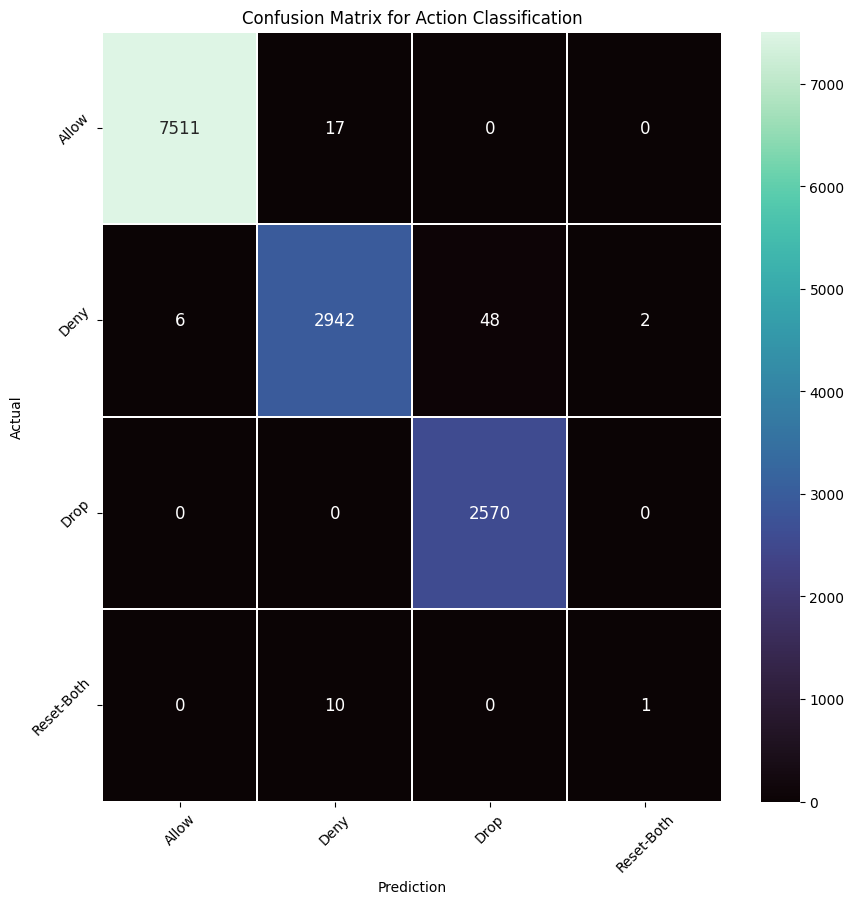

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat,
            cmap= 'mako',
            annot=True,
            fmt='.0f',
            annot_kws={'size':12},
            linecolor='white',
            linewidths=.1,
            )
class_names = ['Allow','Deny','Drop','Reset-Both']
tick_position = [.5,1.5,2.5,3.5]
plt.xticks( ticks=tick_position,labels=class_names, rotation= 45)
plt.yticks(ticks=tick_position, labels = class_names, rotation = 45)
plt.title('Confusion Matrix for Action Classification')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [20]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'C': np.logspace(-3,2,1000)}

random_search = RandomizedSearchCV(LinearSVC(dual=False, class_weight='balanced'),
                                param_distributions=param_dist,
                                n_iter=60,
                                cv=None,
                                verbose=1,
                                n_jobs=-1,
                                random_state=12)

random_search.fit(X,y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RandomizedSearchCV(estimator=LinearSVC(class_weight='balanced', dual=False),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-03, 1.01159111e-03, 1.02331658e-03, 1.03517796e-03,
       1.04717682e-03, 1.05931476e-03, 1.07159340e-03, 1.08401436e-03,
       1.09657929e-03, 1.10928986e-03, 1.12214777e-03, 1.13515471e-03,
       1.14831241e-03, 1.16162263e-03, 1.17508713e-0...
       7.67158118e+01, 7.76050334e+01, 7.85045620e+01, 7.94145172e+01,
       8.03350198e+01, 8.12661920e+01, 8.22081576e+01, 8.31610415e+01,
       8.41249705e+01, 8.51000725e+01, 8.60864770e+01, 8.70843150e+01,
       8.80937190e+01, 8.91148232e+01, 9.01477631e+01, 9.11926760e+01,
       9.22497005e+01, 9.33189772e+01, 9.44006479e+01, 9.54948564e+01,
       9.66017480e+01, 9.77214697e+01, 9.88541702e+01, 1.00000000e+02])},
                   random_state=12, verbose=1)

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test data using the best estimator from RandomizedSearchCV
y_pred = random_search.best_estimator_.predict(X)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y, y_pred)

# Generate the classification report
class_report = classification_report(y, y_pred)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_mat)

print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[37541    95     2     2]
 [    8 14712   263     4]
 [    0     0 12851     0]
 [    0    42     0    12]]

Classification Report:
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00     37640
        deny       0.99      0.98      0.99     14987
        drop       0.98      1.00      0.99     12851
  reset-both       0.67      0.22      0.33        54

    accuracy                           0.99     65532
   macro avg       0.91      0.80      0.83     65532
weighted avg       0.99      0.99      0.99     65532



<hr>

# Part 2 - Stochastic Gradient Descent

<hr>

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier

param_dist = {'alpha': np.logspace(0,2,1000)}

random_search = RandomizedSearchCV(SGDClassifier(class_weight='balanced', loss='log_loss', penalty='l2', early_stopping=True),
                                param_distributions=param_dist,
                                n_iter=60,
                                cv=5,
                                verbose=1,
                                n_jobs=-1,
                                random_state=12)

random_search.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(class_weight='balanced',
                                           early_stopping=True,
                                           loss='log_loss'),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'alpha': array([  1.        ,   1.00462042,   1.00926219,   1.01392541,
         1.01861017,   1.02331658,   1.02804473,   1.03279473,
         1.03756668,   1.04236067,   1.04717682,   1.05201522,
         1.05687597,   1.06175918,   1.06666496,   1.0715934 ,
         1.07654461,   1.08151...
        88.29699955,  88.7049689 ,  89.11482323,  89.52657126,
        89.94022174,  90.35578346,  90.77326525,  91.19267598,
        91.61402457,  92.03731997,  92.46257116,  92.8897872 ,
        93.31897716,  93.75015015,  94.18331535,  94.61848195,
        95.0556592 ,  95.4948564 ,  95.93608287,  96.379348  ,
        96.82466119,  97.27203192,  97.7214697 ,  98.17298406,
        98.62658461,  99.08228099,  99.54008288, 100.        ])},
                   random_state=12, verbose=1)

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test data using the best estimator from RandomizedSearchCV
y_pred = random_search.best_estimator_.predict(X_test)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Generate the classification report
class_report = classification_report(y_test, y_pred)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_mat)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[7528    0    0    0]
 [2998    0    0    0]
 [2570    0    0    0]
 [  11    0    0    0]]

Classification Report:
              precision    recall  f1-score   support

       allow       0.57      1.00      0.73      7528
        deny       0.00      0.00      0.00      2998
        drop       0.00      0.00      0.00      2570
  reset-both       0.00      0.00      0.00        11

    accuracy                           0.57     13107
   macro avg       0.14      0.25      0.18     13107
weighted avg       0.33      0.57      0.42     13107



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

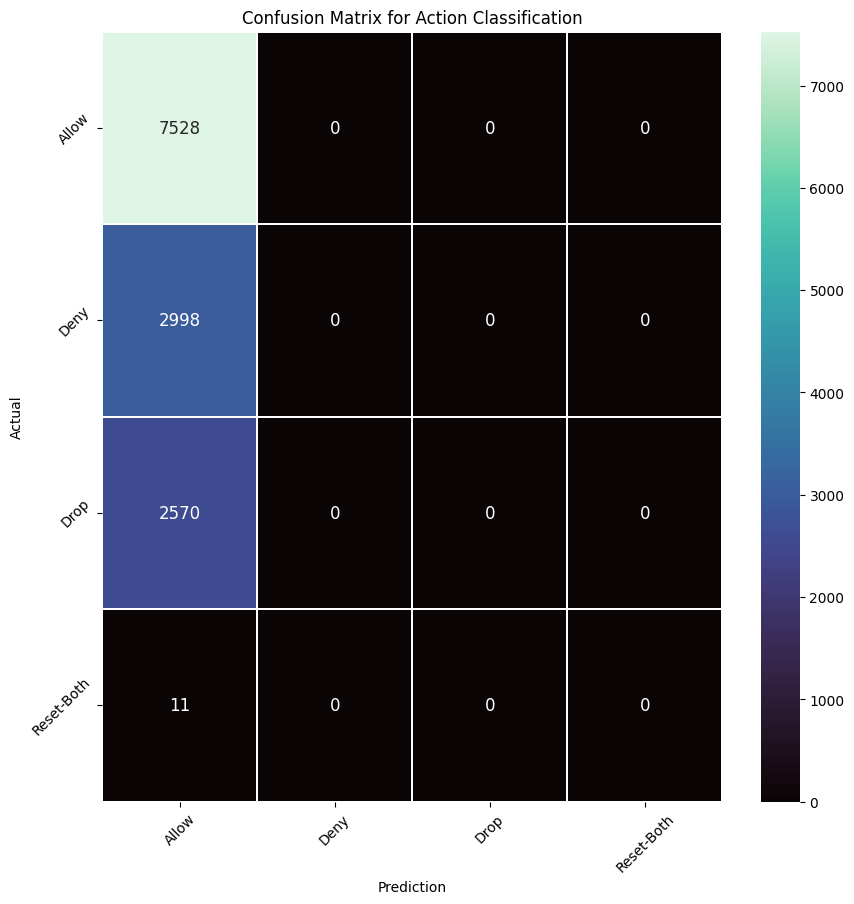

In [24]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat,
            cmap= 'mako',
            annot=True,
            fmt='.0f',
            annot_kws={'size':12},
            linecolor='white',
            linewidths=.1,
            )
class_names = ['Allow','Deny','Drop','Reset-Both']
tick_position = [.5,1.5,2.5,3.5]
plt.xticks( ticks=tick_position,labels=class_names, rotation= 45)
plt.yticks(ticks=tick_position, labels = class_names, rotation = 45)
plt.title('Confusion Matrix for Action Classification')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

## Stochastic Gradient Descent with Early Stopping and CV

In [45]:
random_search = RandomizedSearchCV(
    SGDClassifier(
        class_weight='balanced',
        loss='log_loss',
        penalty='l2',
        early_stopping=True,
        n_iter_no_change= 10
    ),
    param_distributions=param_dist,
    n_iter=60,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=12
)

random_search.fit(X, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(class_weight='balanced',
                                           early_stopping=True, loss='log_loss',
                                           n_iter_no_change=10),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'alpha': array([  1.        ,   1.00462042,   1.00926219,   1.01392541,
         1.01861017,   1.02331658,   1.02804473,   1.03279473,
         1.03756668,   1.04236067,   1.04717682,   1.05201522,
         1.05687597,   1.06175918,   1.06666496,   1.071593...
        88.29699955,  88.7049689 ,  89.11482323,  89.52657126,
        89.94022174,  90.35578346,  90.77326525,  91.19267598,
        91.61402457,  92.03731997,  92.46257116,  92.8897872 ,
        93.31897716,  93.75015015,  94.18331535,  94.61848195,
        95.0556592 ,  95.4948564 ,  95.93608287,  96.379348  ,
        96.82466119,  97.27203192,  97.7214697 ,  98.17298406,
        98.62658461,  99.08228099,  99.54008288, 100.        ])},
                   random_state=12, verbose=1)

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

best_estimator = random_search.best_estimator_

cross_val_scores = cross_val_score(
    best_estimator,
    X,
    y,
    cv=5,
    scoring=make_scorer(accuracy_score)
)


In [47]:
print("Cross-validated scores:", cross_val_scores)
print("Mean accuracy score:", cross_val_scores.mean())
print("Standard deviation of accuracy scores:", cross_val_scores.std())

Cross-validated scores: [0.77874418 0.57434958 0.57439341 0.57439341 0.57439341]
Mean accuracy score: 0.6152547978976546
Standard deviation of accuracy scores: 0.08174469406215643


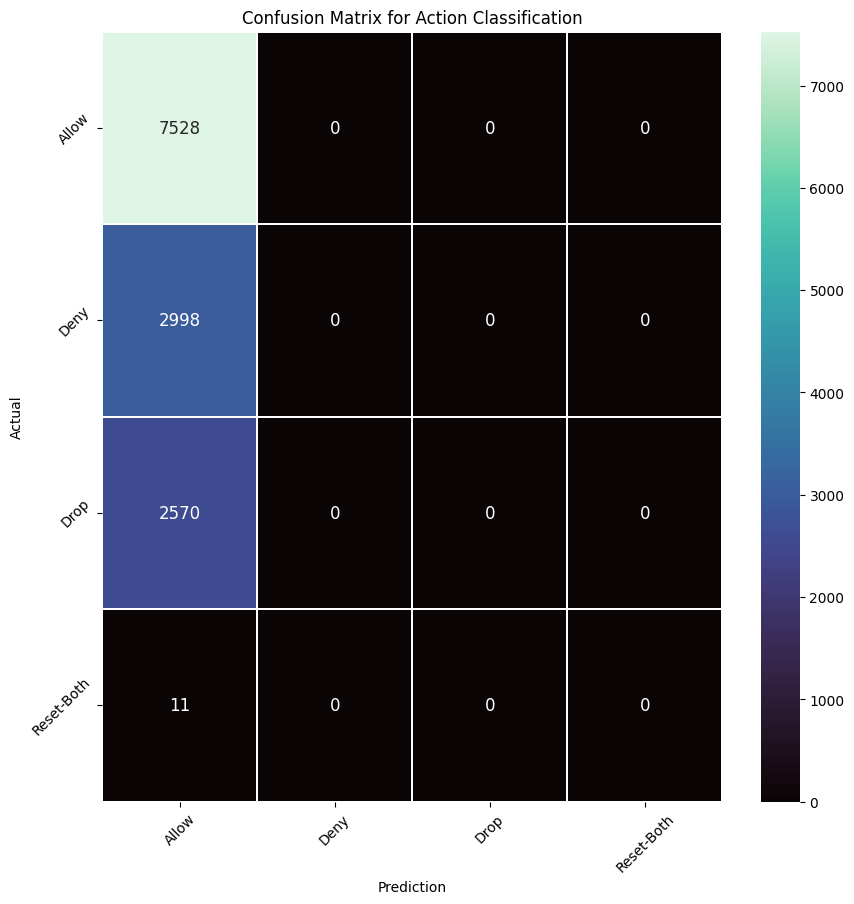

In [48]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat,
            cmap= 'mako',
            annot=True,
            fmt='.0f',
            annot_kws={'size':12},
            linecolor='white',
            linewidths=.1,
            )
class_names = ['Allow','Deny','Drop','Reset-Both']
tick_position = [.5,1.5,2.5,3.5]
plt.xticks( ticks=tick_position,labels=class_names, rotation= 45)
plt.yticks(ticks=tick_position, labels = class_names, rotation = 45)
plt.title('Confusion Matrix for Action Classification')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()